In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import sklearn as sk
from decimal import Decimal
from sklearn import linear_model
from sklearn.preprocessing import label_binarize
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.multiclass import OneVsRestClassifier as ovr
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve, auc, precision_score, recall_score, f1_score 
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB

In [4]:
dr = '~/Projects/video-qoe-labeling/new-data/Skype/'
dtype = {'BitRate': np.float64, 'FreezeRatio': np.float64, 'Freezes': np.int32, 'Freezelength': np.float64, 'Quality': np.float64}
df_all = pd.read_table(dr + 'all-data.txt', delim_whitespace=True, dtype = dtype)
df_all['BitRate'] /= 100  # transforming BitRate to percentages

In [2]:
classifiers = {'Random Forest': RandomForestClassifier(random_state = 1), 
               'Nearest Neighbors': KNeighborsClassifier(),
               'Naive Bayers': GaussianNB(),
               'SVM': SVC(probability = True),
               'MLP': MLPClassifier(random_state = 1, max_iter = 10000),
               'AdaBoost': AdaBoostClassifier(random_state = 1)
              }

params = {'Random Forest': {'n_estimators': range(1, 21), 'criterion': ('gini', 'entropy')},
          'Nearest Neighbors': {'n_neighbors':range(1, 11)},
          'Naive Bayers': {},
          'SVM': {'kernel':('poly', 'rbf', 'sigmoid'), 'C':[0.1, 1, 10]},
          'MLP': {'hidden_layer_sizes': [(5,), (10,), (25,), (50,), (100,), (200,)], 
                  'alpha': [0.0001, 0.001],
                  'activation': ('logistic', 'tanh', 'relu'), 
                  'solver': ('lbfgs', 'sgd', 'adam')},
          'AdaBoost': {'n_estimators': [10, 25, 50, 100], 'learning_rate': [0.01, 0.1, 1, 10]}
         }

In [3]:
# get (X, y) and set fold
X, y = np.array(df_all[['BitRate', 'FreezeRatio']]), np.array(df_all['Quality'])
accuracies = {}
confusion = {}
fold = 10

NameError: name 'df_all' is not defined

In [8]:
# function for obtaining best estimator using grid search
def grid_search(estimator, params):
    clf = GridSearchCV(estimator, params)
    clf.fit(X, y)
    return (clf.best_estimator_, clf.best_score_)

# function for performing k-fold cross validation 
def k_Fold_CV(estimator, n):
    accuracies = []
    confusion = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        pred = estimator.fit(X[train], y[train]).predict(X[test])
        accuracies.append(estimator.score(X[test], y[test]))
        confusion.append(confusion_matrix(y[test], pred))
    return (accuracies, confusion)

In [12]:
best_classifiers = {}
for k in classifiers.keys():
    best_classifiers[k], _ = grid_search(classifiers[k], params[k])
    accuracies[k], confusion[k] = k_Fold_CV(best_classifiers[k], fold)

In [13]:
for k, v in accuracies.items():
    print(k)
    print("{}_fold accuracies: ".format(fold), np.around(v, decimals = 3))
    print("Average accuracy: {0:0.3f}".format(np.mean(v)))
    print("#################################")

Random Forest
10_fold accuracies:  [ 0.757  0.865  0.784  0.865  0.889  0.972  0.75   0.694  0.75   0.833]
Average accuracy: 0.816
#################################
Nearest Neighbors
10_fold accuracies:  [ 0.811  0.838  0.757  0.838  0.889  0.972  0.778  0.778  0.639  0.833]
Average accuracy: 0.813
#################################
Naive Bayers
10_fold accuracies:  [ 0.946  0.811  0.784  0.73   0.806  0.944  0.806  0.778  0.694  0.75 ]
Average accuracy: 0.805
#################################
SVM
10_fold accuracies:  [ 0.892  0.865  0.784  0.838  0.861  0.972  0.75   0.694  0.667  0.861]
Average accuracy: 0.818
#################################
MLP
10_fold accuracies:  [ 0.865  0.838  0.865  0.811  0.889  0.972  0.806  0.806  0.583  0.833]
Average accuracy: 0.827
#################################
AdaBoost
10_fold accuracies:  [ 0.919  0.865  0.811  0.838  0.889  0.861  0.667  0.444  0.5    0.639]
Average accuracy: 0.743
#################################


In [14]:
# binarize labels
classes = range(3)
y_bin = label_binarize(y, classes = classes)

# function for computing the ROC curves in k-fold CV
def k_Fold_roc(clf, n):
    aucs = []
    kf = KFold(n_splits = n)
    for train, test in kf.split(X):
        _, _, a = get_roc(X[train], y_bin[train], X[test], y_bin[test], clf)
        aucs.append(a)
    return aucs 

def plot_roc(fpr, tpr, roc_auc, clf_name, lb):
    plt.figure()
    plt.plot(fpr, tpr, label='ROC curve (area = {0:.2f})'.format(roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic: {}, Class {}'.format(clf_name, lb))
    plt.legend(loc="lower right")
    plt.show()
        
def get_roc(X_tr, y_tr, X_te, y_te, clf):
    fpr = {}
    tpr = {}
    roc_auc = {}
    y_score = ovr(clf).fit(X_tr, y_tr).predict_proba(X_te)
    for i in range(len(classes)):
        fpr[i], tpr[i], _ = roc_curve(y_te[:, i], y_score[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
    return (fpr, tpr, roc_auc)

In [15]:
# get k-fold CV roc data for each classifier
aucs = {}
for k, v in best_classifiers.items():
    aucs[k] = k_Fold_roc(v, fold)

In [16]:
for k, v in aucs.items():  # v is a list of dictionaries
    print(k)
    print("{}_fold AUCs: ".format(fold))
    for x in v:  # x is a dictionary {'label': AUC}
        print({l:'{0:5.3f}'.format(x[l]) for l in x.keys()})
    print("#################################")

Random Forest
10_fold AUCs: 
{0: '1.000', 1: '0.843', 2: '0.905'}
{0: '0.974', 1: '0.869', 2: '0.904'}
{0: '1.000', 1: '0.915', 2: '0.904'}
{0: '0.967', 1: '0.820', 2: '0.933'}
{0: '0.957', 1: '0.900', 2: '0.977'}
{0: '0.973', 1: '1.000', 2: '0.962'}
{0: '0.968', 1: '0.844', 2: '0.883'}
{0: '1.000', 1: '0.846', 2: '0.819'}
{0: '1.000', 1: '0.769', 2: '0.805'}
{0: '1.000', 1: '0.862', 2: '0.907'}
#################################
Nearest Neighbors
10_fold AUCs: 
{0: '1.000', 1: '0.880', 2: '0.939'}
{0: '0.976', 1: '0.902', 2: '0.969'}
{0: '0.997', 1: '0.908', 2: '0.952'}
{0: '0.991', 1: '0.913', 2: '0.972'}
{0: '0.958', 1: '0.921', 2: '0.969'}
{0: '1.000', 1: '1.000', 2: '0.960'}
{0: '0.957', 1: '0.831', 2: '0.917'}
{0: '1.000', 1: '0.924', 2: '0.908'}
{0: '1.000', 1: '0.796', 2: '0.805'}
{0: '1.000', 1: '0.842', 2: '0.890'}
#################################
Naive Bayers
10_fold AUCs: 
{0: '1.000', 1: '0.439', 2: '0.939'}
{0: '0.985', 1: '0.413', 2: '0.978'}
{0: '1.000', 1: '0.513', 2: 

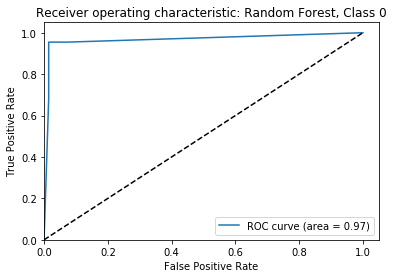

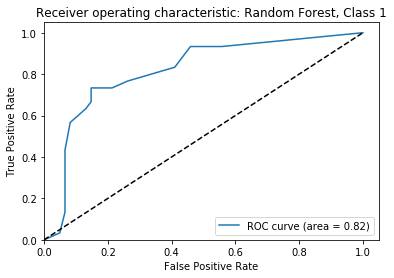

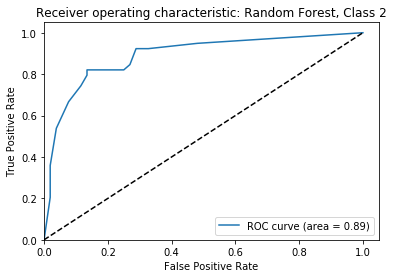

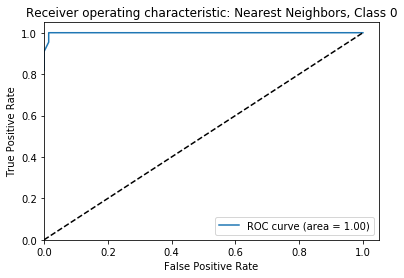

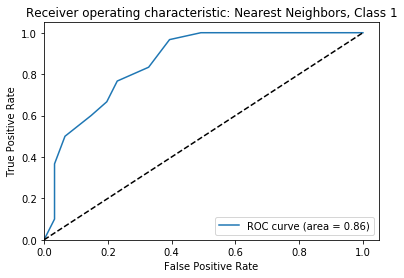

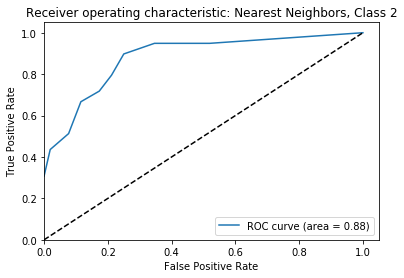

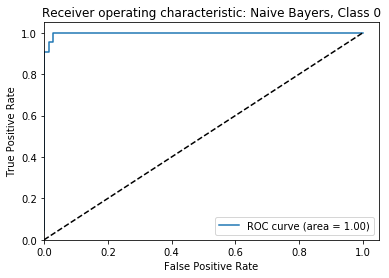

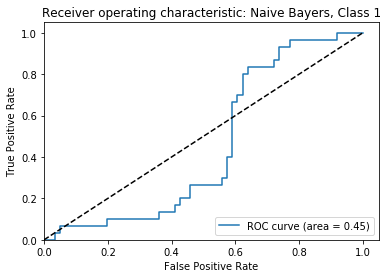

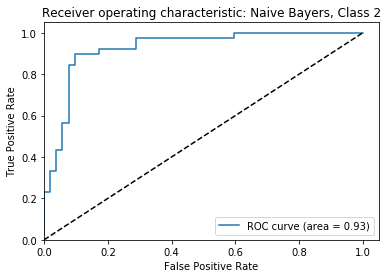

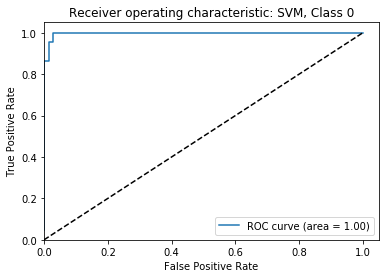

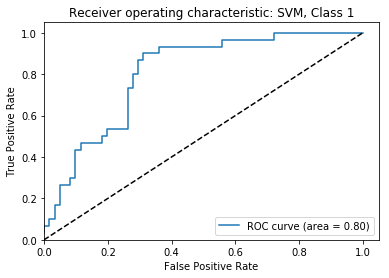

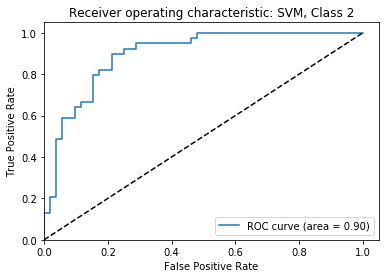

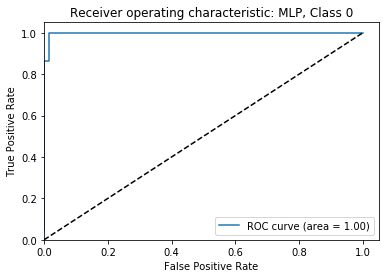

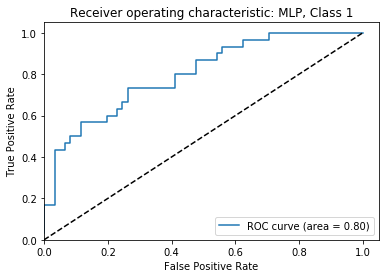

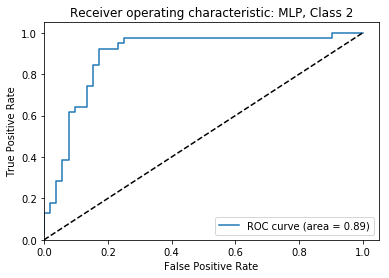

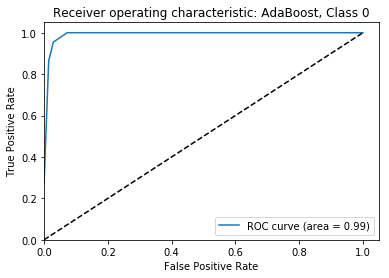

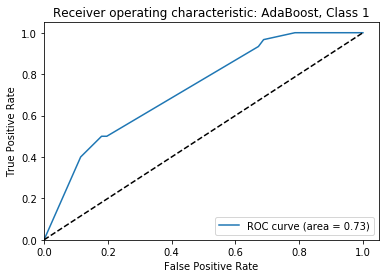

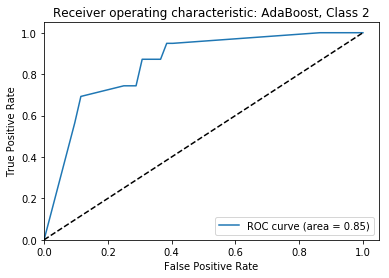

In [17]:
# ROC curves for a random train-test split for each classifier
X_train, X_test, y_train, y_test = train_test_split(X, y_bin, test_size = 0.25, random_state = 0)

for k, v in best_classifiers.items():
    fpr, tpr, roc_auc = get_roc(X_train, y_train, X_test, y_test, v)
    for i in classes:
        plot_roc(fpr[i], tpr[i], roc_auc[i], k, i)

# S2, S6 and Pixel Analysis

In [ ]:
df = {}
df['s2'] = pd.rhttp://localhost:8888/notebooks/Projects/video-qoe-labeling/scripts/CSE523_Regression.ipynb#S2,-S6-and-Pixel-Analysisead_table(dr + 's2.txt', delim_whitespace=True, dtype = dtype)
df['s6'] = pd.read_table(dr + 's6.txt', delim_whitespace=True, dtype = dtype)
df['px'] = pd.read_table(dr + 'pixel.txt', delim_whitespace=True, dtype = dtype)